In [45]:
##### IMPORTS #####
import os
import pandas as pd
import numpy as np
import torch 
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models
import torch.optim as optim

# Import Lung custom dataset
from LungData import Lung
from tqdm.notebook import tqdm

# For visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For evaluation
import torchmetrics
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Creating a list of folders (classes) in train folder
folders = [folder for folder in os.listdir("train/") if os.path.isdir(os.path.join("train/", folder)) and folder.startswith("lung")]

In [3]:
# Path to train and test folders
train_directory = "train/"
test_directory = "test/"

In [4]:
# Defining function which removes unnecessary folders in directory
def filter_directory(directory):
    for root, dirs, files in os.walk(directory):
        # Check if the current directory is the .ipynb_checkpoints folder
        if ".ipynb_checkpoints" in dirs:
            # Get the path to the .ipynb_checkpoints folder
            checkpoints_folder = os.path.join(root, ".ipynb_checkpoints")

            # Delete the .ipynb_checkpoints folder
            os.rmdir(checkpoints_folder)

In [5]:
filter_directory(train_directory)
filter_directory(test_directory)

In [7]:
# Resize images to 224x224 from 784x784
transform = transforms.Compose([transforms.Resize((224, 224)), 
                               transforms.ToTensor()
                               ])

In [8]:
train_dataset = ImageFolder(root=train_directory, transform=transform)

In [9]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 12000
    Root location: train/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [10]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size = 64)

In [11]:
lung = Lung(transform)

In [24]:
# Example of image dimension and label 
img, label = lung[0]
print("Image dimensions:", img.shape)
print("Label:", label)

Image dimensions: torch.Size([3, 224, 224])
Label: 2


In [12]:
# Dictionary for index to class
idx_to_class = {v: k for k, v in lung.class_map.items()}

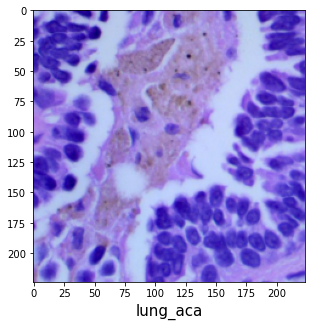

In [19]:
plt.figure(figsize=(5,5))
plt.imshow(img.permute(1,2,0))
plt.xlabel(idx_to_class[label], fontsize=15)
plt.show()

In [16]:
# Function to determine the mean and standard deviation
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels  
        # 0,2,3  batch, height, width, channel
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = ((channels_squared_sum / num_batches) - (mean ** 2))**0.5

    return mean, std

In [17]:
mean, std = get_mean_and_std(train_loader)
print(mean)
print(std)

tensor([0.6699, 0.5344, 0.8513])
tensor([0.1658, 0.1976, 0.1073])


In [13]:
mean = [0.6699, 0.5344, 0.8513]
std = [0.1658, 0.1976, 0.1073]

In [14]:
mean = torch.FloatTensor(mean)
std = torch.FloatTensor(std)

In [15]:
transform = transforms.Compose([transforms.Resize((224, 224)), 
                               transforms.ToTensor(),
                               transforms.Normalize(mean, std)
                               ])

In [16]:
lung_transform = Lung(transform=transform)

In [6]:
img, label = lung_transform[0]
print("Image dimensions:", img.shape)
print("Label:", label)

Image dimensions: torch.Size([3, 224, 224])
Label: 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


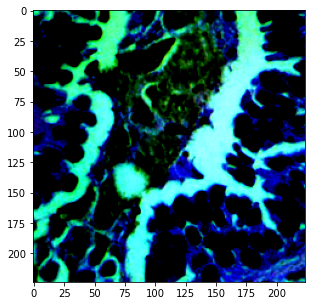

In [7]:
plt.figure(figsize=(5,5))
plt.imshow(img.permute(1,2,0))

In [17]:
train_dataset = ImageFolder(root=train_directory, transform=transform)
test_dataset = ImageFolder(root=test_directory, transform=transform)

In [18]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

### Training Loop Step

1. Forward Pass
2. Calculate loss
3. Zero gradients
4. Backpropagation
5. Optimiser Step

In [19]:
device = torch.device("mps")

In [20]:
# Define model and features
model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 3)
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.05)
scheduler = StepLR(optimiser, step_size=2)

# Define path to save best weights for respective model
PATH = "best_model.pth"
best_loss = float("inf")
best_weights = None

In [32]:
import time 

start_time = time.time()

epochs = 10

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for epoch in range(epochs):
    print(f"Epoch {epoch} running")
    """ Training Phase """
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    # Load batch data of images
    for b, (inputs, labels) in enumerate(train_loader):
        
        b += 1
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero Gradient (Optimiser)
        # Forward inputs to get output
        optimiser.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        # Calculate Loss
        loss = criterion(outputs, labels)
        
        # Update weights (Backpropagation)
        loss.backward()
        optimiser.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
        if b%64 == 0:
            acc = running_corrects.item()*100/(b*64)
            print(f'Epoch: {epoch}, Batch: {b}, Loss: {loss.item()}, accuracy: {acc}')
        
    
    train_losses.append(loss.item())
    train_correct.append(running_corrects.item())
    
    # Update Scheduler
    scheduler.step()
    
    """ Testing Phase """
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in tqdm(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        
        # Saving current best model
        
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_weights = model.state_dict()
            
            torch.save(best_weights, PATH)
        
        print('[Test {}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time()- start_time))

Epoch 0 running
Epoch: 0, Batch: 64, Loss: 0.29005271196365356, accuracy: 72.998046875
Epoch: 0, Batch: 128, Loss: 0.2427135407924652, accuracy: 80.810546875


  0%|          | 0/47 [00:00<?, ?it/s]

[Test 0] Loss: 0.3747 Acc: 82.9333% Time: 305.5018s
Epoch 1 running
Epoch: 1, Batch: 64, Loss: 0.3573776185512543, accuracy: 90.33203125
Epoch: 1, Batch: 128, Loss: 0.20594966411590576, accuracy: 90.087890625


  0%|          | 0/47 [00:00<?, ?it/s]

[Test 1] Loss: 0.3300 Acc: 88.6667% Time: 608.7949s
Epoch 2 running
Epoch: 2, Batch: 64, Loss: 0.21175378561019897, accuracy: 91.552734375
Epoch: 2, Batch: 128, Loss: 0.19716155529022217, accuracy: 92.2607421875


  0%|          | 0/47 [00:00<?, ?it/s]

[Test 2] Loss: 0.1660 Acc: 93.1000% Time: 915.2610s
Epoch 3 running
Epoch: 3, Batch: 64, Loss: 0.15332065522670746, accuracy: 92.333984375
Epoch: 3, Batch: 128, Loss: 0.22144082188606262, accuracy: 92.822265625


  0%|          | 0/47 [00:00<?, ?it/s]

[Test 3] Loss: 0.1642 Acc: 94.0000% Time: 1221.5821s
Epoch 4 running
Epoch: 4, Batch: 64, Loss: 0.13805410265922546, accuracy: 93.4326171875
Epoch: 4, Batch: 128, Loss: 0.14373920857906342, accuracy: 93.359375


  0%|          | 0/47 [00:00<?, ?it/s]

[Test 4] Loss: 0.1367 Acc: 94.9333% Time: 1528.5640s
Epoch 5 running
Epoch: 5, Batch: 64, Loss: 0.13643556833267212, accuracy: 93.798828125
Epoch: 5, Batch: 128, Loss: 0.14404809474945068, accuracy: 93.73779296875


  0%|          | 0/47 [00:00<?, ?it/s]

[Test 5] Loss: 0.1368 Acc: 95.1667% Time: 1836.1661s
Epoch 6 running
Epoch: 6, Batch: 64, Loss: 0.20153886079788208, accuracy: 93.701171875
Epoch: 6, Batch: 128, Loss: 0.15602149069309235, accuracy: 93.85986328125


  0%|          | 0/47 [00:00<?, ?it/s]

[Test 6] Loss: 0.1334 Acc: 95.0000% Time: 2140.3999s
Epoch 7 running
Epoch: 7, Batch: 64, Loss: 0.1614392250776291, accuracy: 93.896484375
Epoch: 7, Batch: 128, Loss: 0.11859127134084702, accuracy: 94.03076171875


  0%|          | 0/47 [00:00<?, ?it/s]

[Test 7] Loss: 0.1343 Acc: 95.1333% Time: 2448.7718s
Epoch 8 running
Epoch: 8, Batch: 64, Loss: 0.10107502341270447, accuracy: 93.8232421875
Epoch: 8, Batch: 128, Loss: 0.07535617053508759, accuracy: 93.73779296875


  0%|          | 0/47 [00:00<?, ?it/s]

[Test 8] Loss: 0.1338 Acc: 95.0667% Time: 2754.9926s
Epoch 9 running
Epoch: 9, Batch: 64, Loss: 0.19042035937309265, accuracy: 93.9208984375
Epoch: 9, Batch: 128, Loss: 0.14603886008262634, accuracy: 93.994140625


  0%|          | 0/47 [00:00<?, ?it/s]

[Test 9] Loss: 0.1347 Acc: 95.0000% Time: 4182.1573s


In [21]:
# Load model with best weights
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [22]:
# Evaluate model against test data
model.to(device)

model.eval()

preds = []
labels = []

with torch.no_grad():
    correct = 0
    for data, label in tqdm(test_dataset):
        data = data.to(device).float().unsqueeze(0)
        y_val = model(data)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == label).sum()
        preds.append(predicted)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/3000 [00:00<?, ?it/s]

In [23]:
acc = torchmetrics.Accuracy()(preds, labels)
precision = torchmetrics.Precision()(preds, labels)
recall = torchmetrics.Recall()(preds, labels)


print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")

Val Accuracy: 0.949999988079071
Val Precision: 0.949999988079071
Val Recall: 0.949999988079071


In [24]:
cm = confusion_matrix(labels, preds)

In [25]:
df = pd.DataFrame(cm, index=[idx_to_class[i] for i in range(3)], columns=[idx_to_class[i] for i in range(3)])

Text(0.5, 1.0, 'Confusion Matrix of Lung Classification')

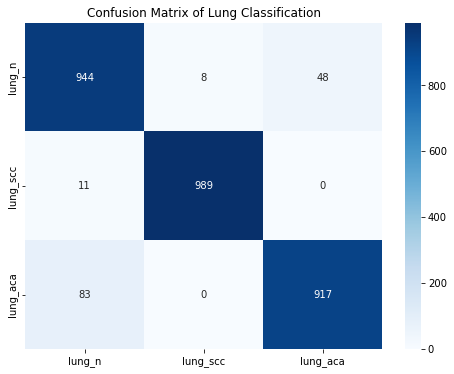

In [26]:
plt.figure(figsize=(8,6))
sns.heatmap(df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix of Lung Classification')

In [46]:
print(classification_report(preds, labels))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      1038
           1       0.99      0.99      0.99       997
           2       0.92      0.95      0.93       965

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95      0.95      0.95      3000

